In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [4]:
# transformations
transform = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# import the data and simultaneously apply the transform
trainset = tv.datasets.CIFAR10(
    root="../Datasets/", train=True, download=True, transform=transform
)
testset = tv.datasets.CIFAR10(
    root="../Datasets/", train=False, download=True, transform=transform
)

# transform to dataloaders
batchsize = 32
train_loaderFull = DataLoader(
    trainset, batch_size=batchsize, shuffle=True, drop_last=True, generator=torch.Generator(device=device)
)
test_loaderFull = DataLoader(
    testset, batch_size=256, generator=torch.Generator(device=device)
)

# Create smaller DataLoaders with only 2k images (used later)

trainsetSmall = torch.utils.data.Subset(trainset, range(2000))
train_loaderSmall = DataLoader(
    trainsetSmall,
    batch_size=batchsize,
    shuffle=True,
    generator=torch.Generator(device=device),
)

testsetSmall = torch.utils.data.Subset(testset, range(2000))
test_loaderSmall = DataLoader(
    testsetSmall,
    batch_size=batchsize,
    shuffle=True,
    generator=torch.Generator(device=device),
)

Files already downloaded and verified
Files already downloaded and verified


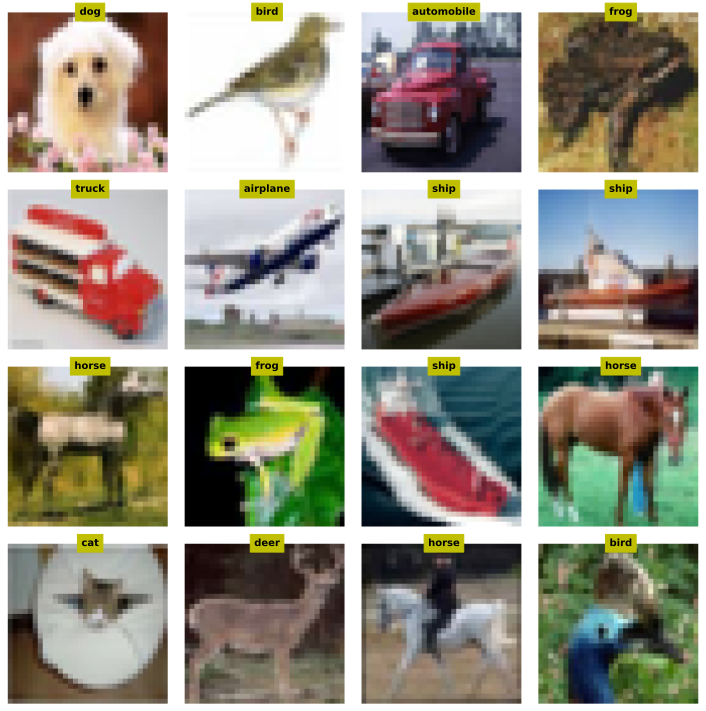

In [5]:
# inspect a few random images

X, y = next(iter(train_loaderSmall))

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = trainset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
# create a class for the model
def makeTheAENet(printtoggle=False):

    class aenet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()

            # print toggle
            self.print = printtoggle

            ### -------------- encoding layers -------------- ###
            # first convolution layer
            self.encconv1 = nn.Conv2d(
                3, 16, 4, padding=1, stride=2
            )  # note: using stride instead of pool to downsample
            # output size: (32+2*1-4)/2 + 1 = 16

            # second convolution layer
            self.encconv2 = nn.Conv2d(16, 32, 4, padding=1, stride=2)
            # output size: (16+2*1-4)/2 + 1 = 8

            # third convolution layer
            self.encconv3 = nn.Conv2d(32, 64, 4, padding=1, stride=2)
            # output size: (8+2*1-4)/2 + 1 = 4

            ### -------------- decoding layers -------------- ###

            # first convolution layer
            self.decconv1 = nn.ConvTranspose2d(64, 32, 4, padding=1, stride=2)

            # second convolution layer
            self.decconv2 = nn.ConvTranspose2d(32, 16, 4, padding=1, stride=2)

            # third convolution layer (output)
            self.decconv3 = nn.ConvTranspose2d(16, 3, 4, padding=1, stride=2)

        def forward(self, x):

            if self.print:
                print(f"Input: {list(x.shape)}")

            # first encoder layer
            x = F.leaky_relu(self.encconv1(x))
            if self.print:
                print(f"First encoder block: {list(x.shape)}")

            # first encoder layer
            x = F.leaky_relu(self.encconv2(x))
            if self.print:
                print(f"Second encoder block: {list(x.shape)}")

            # first encoder layer
            x = F.leaky_relu(self.encconv3(x))
            if self.print:
                print(f"Third encoder block: {list(x.shape)}")

            # first decoder block
            x = F.leaky_relu(self.decconv1(x))
            if self.print:
                print(f"First decoder block: {list(x.shape)}")

            # second decoder block
            x = F.leaky_relu(self.decconv2(x))
            if self.print:
                print(f"Second decoder block: {list(x.shape)}")

            # third decoder block (output)
            x = F.leaky_relu(self.decconv3(x))
            if self.print:
                print(f"Decoder output: {list(x.shape)}")

            return x

    # create the model instance
    net = aenet(printtoggle)

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    return net, lossfun, optimizer

In [8]:
# test the model with one batch
aenet, lossfun, optimizer = makeTheAENet(True)

X, y = next(iter(train_loaderSmall))
X = X.to(device)
y = y.to(device)
yHat = aenet(X)

# now compute the loss
loss = lossfun(yHat, X)
print(" ")
print("Loss:")
print(loss)

Input: [32, 3, 32, 32]
First encoder block: [32, 16, 16, 16]
Second encoder block: [32, 32, 8, 8]
Third encoder block: [32, 64, 4, 4]
First decoder block: [32, 32, 8, 8]
Second decoder block: [32, 16, 16, 16]
Decoder output: [32, 3, 32, 32]
 
Loss:
tensor(0.2664, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
# Create the function to train the AE model
# a function that trains the model


def function2trainTheAEModel(net, lossfun, optimizer):

    # number of epochs
    numepochs = 15

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        net.train()  # switch to train mode
        batchLoss = []

        for X, y in train_loaderFull:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss and accuracy from this batch
            batchLoss.append(loss.cpu().item())
        # end of batch loop...

        # and get average losses and accuracies across the batches
        trainLoss[epochi] = np.mean(batchLoss)

        #### test performance (here done in batches!)
        net.eval()  # switch to test mode
        batchLoss = []

        for X, y in test_loaderFull:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            with torch.no_grad():
                yHat = net(X)
                loss = lossfun(yHat, X)

            # loss and accuracy from this batch
            batchLoss.append(loss.cpu().item())
        # end of batch loop...

        # and get average losses and accuracies across the batches
        testLoss[epochi] = np.mean(batchLoss)

    # end epochs

    # function output
    return trainLoss, testLoss, net

In [10]:
# create a new model (comment out to re-train)
netAE, lossfun, optimizer = makeTheAENet()

trainLossAE, testLossAE, netAE = function2trainTheAEModel(netAE, lossfun, optimizer)

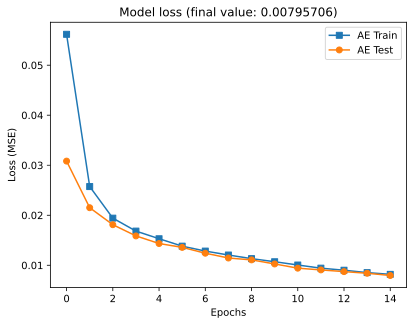

In [11]:
plt.plot(trainLossAE.cpu(), "s-", label="AE Train")
plt.plot(testLossAE.cpu(), "o-", label="AE Test")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model loss (final value: %g)" % testLossAE[-1])
plt.legend()

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020441711..0.7647326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0056709647..0.98440886].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.042832613..0.9728593].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043430686..0.81919783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04060757..1.0135577].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07428461..0.9724746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ran

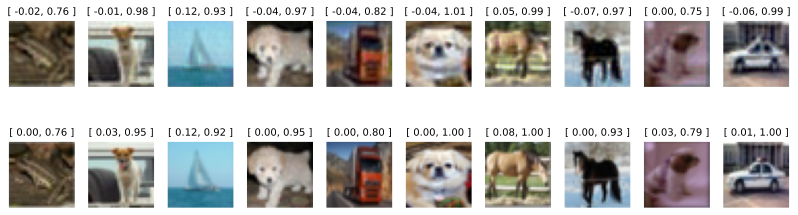

In [12]:
## show some random examples

# get some data
X, y = next(iter(test_loaderSmall))

# forward pass and loss
netAE.cpu()
netAE.eval()  # switch to test mode
yHat = netAE(X)


fig, axs = plt.subplots(2, 10, figsize=(14, 4))

for i in range(10):
    pic = yHat[i, :, :, :].detach().numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization
    axs[0, i].imshow(pic)
    axs[0, i].set_title(f"[ {np.min(pic):.2f}, {np.max(pic):.2f} ]", fontsize=10)
    axs[0, i].axis("off")

    pic = X[i, :, :, :].detach().numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization
    axs[1, i].imshow(pic)
    axs[1, i].set_title(f"[ {np.min(pic):.2f}, {np.max(pic):.2f} ]", fontsize=10)
    axs[1, i].axis("off")


plt.show()